# Implementing Adaptive Latent Space Augmentation for a Variational Autoencoder
This project aims to enhance image generation using adaptive data augmentation techniques applied at the latent space level. It investigates the integration of stronger augmentations within autoencoders to improve the visual quality of generated images. The focus is on interpretability and control of the latent space for better understanding and customization of image generation processes.



## Notebook Code Abstract

The notebook code provided in this repository demonstrates the implementation of adaptive data augmentation techniques within an autoencoder framework for image generation tasks. 

1. Importing necessary libraries and modules
2. Load and preprocess the dataset
3. Defining the Model Architecture and configuration
4. Latent Space Augmentations
5. Composed Augmentation framework
6. Incorporating Adaptivity in the augmentation framework
7. Plotting the evolution of paramters and loss functions.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Libraries

In the very first step, essential libraries and modules were imported for data manipulation, visualization, and model building. Specific functionalities from TensorFlow, scikit-learn, and Keras were imported to facilitate data preprocessing, model evaluation, and neural network construction.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import os
import cv2
import time
import glob
#import tensorflow_probability as tfp

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, losses
from tensorflow.keras.layers import Layer, Input, Conv2D, Dense, Flatten, Reshape, Lambda, Dropout
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### 3.1 Load the CelebA dataset
This code initializes variables for batch size and desired number of files, then retrieves JPEG file names from a directory. It selects a subset of the files, splits them into training and testing sets, and prints the number of images in each split. It emphasizes that only file names are loaded, and during training, images will be loaded in batches as needed.

Default configurations for the below code snippet include
  - num_files: number of files - 100000 (we are limiting the number due to limit on computational resources)
  - data folder path (`data_folder = '../data/img_align_celeba'`),
  - test size of 20% (`test_size=0.2`).

In [ ]:
# Define the batch size
batch_size = 32
# Define the directory containing the CelebA dataset
celebA_dir = '/content/drive/MyDrive/Master_project/CelebA_data/data/img_align_celeba'
num_files = 200 # Define the desired number of files


# List all JPEG files in the directory
image_filenames = glob.glob(os.path.join(celebA_dir, '*.jpg'))

# Take only the first 'num_files' files
image_filenames = image_filenames[:num_files]

# Check if there are any JPEG files found
if not image_filenames:
    raise ValueError("No JPEG files found in the directory.")

# Split the dataset into training and testing sets
train_files, test_files = train_test_split(image_filenames, test_size=0.2, random_state=42)

# Print the number of images in each split
print("Number of train images:", len(train_files))
print("Number of test images:", len(test_files))




Number of train images: 160
Number of test images: 40


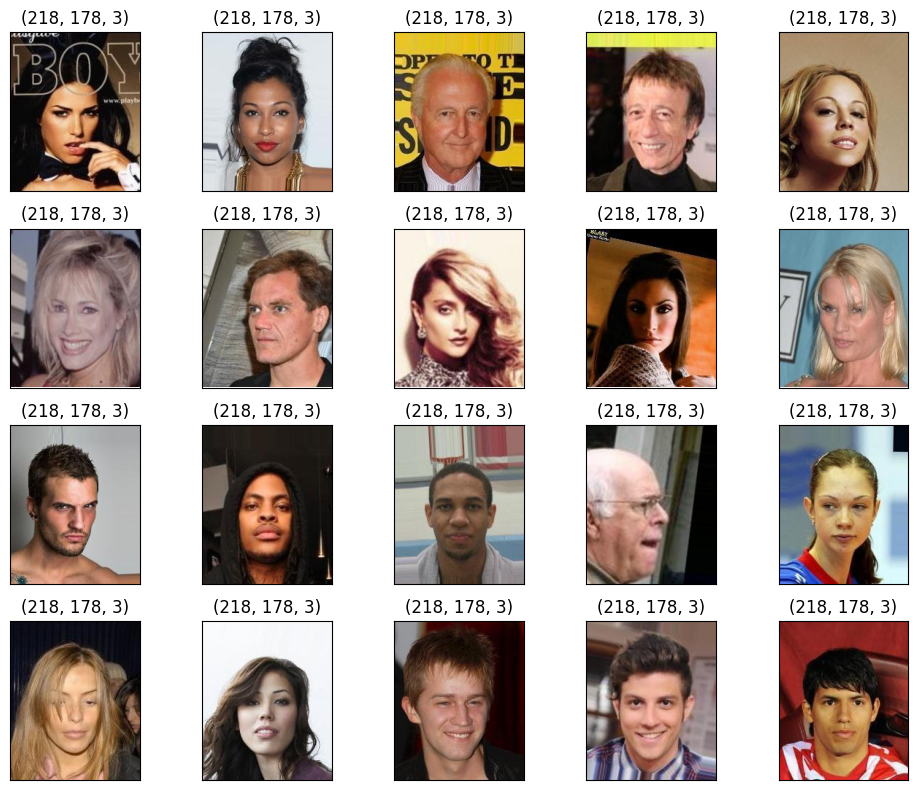

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(20):
    img = plt.imread(train_files[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(img.shape)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

### 3.2 Preprocessing and Resizing

This Python function preprocesses a list of images by loading, resizing, converting them from BGR to RGB color space, and normalizing them to a target size of 128x128 pixels.
It first checks if the image exists before processing to handle cases where the image file may be corrupted or missing.
The function then loads each image using OpenCV's imread function, resizes them to the specified target size, and converts them to RGB color space.

Finally, it converts the list of processed images into a numpy array and scales the pixel values between 0 and 1 for numerical stability during training.



In [ ]:
def preprocess_images(image_filenames, target_size=(128, 128)):
    # Load, resize, and convert images to RGB
    images = [cv2.cvtColor(cv2.resize(cv2.imread(filename), target_size), cv2.COLOR_BGR2RGB) for filename in image_filenames if cv2.imread(filename) is not None]
    # Convert images to float32 and normalize
    preprocessed_images = np.array(images).astype('float32') / 255.0
    return preprocessed_images

In [ ]:
target_size = (128,128)
# Load and preprocess test images
test_images = preprocess_images(test_files, target_size)

In [ ]:
print(f"test_images:{test_images.shape}")

test_images:(200, 128, 128, 3)


In [ ]:
# Display a subset of preprocessed images
num_images_to_display = 5
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(test_images[i])
    ax.axis('off')
plt.show()

### Model Overview

The Variational Autoencoder (VAE) is a generative model used for unsupervised learning of latent representations in data. It comprises an encoder network that maps input data to a latent space representation and a decoder network that reconstructs the input data from the latent space. VAEs are trained using a probabilistic framework, optimizing a reconstruction loss and a regularization term that encourages the learned latent space to follow a prior distribution, typically a Gaussian.

### 3.3 Model Architecture

The VAE architecture consists of two main components:

1. **Encoder**: The encoder network takes input data and maps it to a latent space representation. It typically comprises several convolutional layers followed by dense layers to map the input data to the mean and variance parameters of the latent Gaussian distribution.

2. **Decoder**: The decoder network takes samples from the latent space and reconstructs the input data. It mirrors the structure of the encoder network, usually comprising deconvolutional layers to upsample the latent representation back to the original input dimensions.

### Default Configuration

- Input images are resized to a fixed size before being fed into the network.
- The encoder network consists of several convolutional layers with leaky ReLU activations and batch normalization.
- The decoder network mirrors the architecture of the encoder, with deconvolutional layers and ReLU activations.
- The latent space dimensionality (`z_dim`) is specified when initializing the VAE model.
- The final layer of the decoder uses a sigmoid activation function to ensure pixel values are in the range [0, 1].
- Training is typically performed using a combination of reconstruction loss (e.g., mean squared error) and a regularization term (e.g., Kullback-Leibler divergence) to encourage the latent space to follow a prior distribution.

In [ ]:
class GaussianSampling(Layer):
    def call(self, inputs):
        means, logvar = inputs
        epsilon = tf.random.normal(shape=tf.shape(means), mean=0., stddev=1.)
        samples = means + tf.exp(0.5*logvar)*epsilon

        return samples

class DownConvBlock(Layer):
    count = 0
    def __init__(self, filters, kernel_size=(3,3), strides=1, padding='same'):
        super(DownConvBlock, self).__init__(name=f"DownConvBlock_{DownConvBlock.count}")
        DownConvBlock.count+=1
        self.forward = Sequential([Conv2D(filters, kernel_size, strides, padding)])
        self.forward.add(BatchNormalization())
        self.forward.add(layers.LeakyReLU(0.2))

    def call(self, inputs):
        return self.forward(inputs)

class UpConvBlock(Layer):
    count = 0
    def __init__(self, filters, kernel_size=(3,3), padding='same'):
        super(UpConvBlock, self).__init__(name=f"UpConvBlock_{UpConvBlock.count}")
        UpConvBlock.count += 1
        self.forward = Sequential([Conv2D(filters, kernel_size, 1, padding),])
        self.forward.add(layers.LeakyReLU(0.2))
        self.forward.add(UpSampling2D((2,2)))

    def call(self, inputs):
        return self.forward(inputs)

class Encoder(Layer):
    def __init__(self, z_dim, name='encoder'):
        super(Encoder, self).__init__(name=name)

        self.features_extract = Sequential([
            DownConvBlock(filters = 32, kernel_size=(3,3), strides=2),
            DownConvBlock(filters = 32, kernel_size=(3,3), strides=2),
            DownConvBlock(filters = 64, kernel_size=(3,3), strides=2),
            DownConvBlock(filters = 64, kernel_size=(3,3), strides=2),
            Flatten()])

        self.dense_mean = Dense(z_dim, name='mean')
        self.dense_logvar = Dense(z_dim, name='logvar')
        self.sampler = GaussianSampling()

    def call(self, inputs):
        x = self.features_extract(inputs)
        mean = self.dense_mean(x)
        logvar = self.dense_logvar(x)
        z = self.sampler([mean, logvar])
        return z, mean, logvar

class Decoder(Layer):
    def __init__(self, z_dim, name='decoder'):
        super(Decoder, self).__init__(name=name)

        self.forward = Sequential([
                        Dense(8*8*64, activation='relu'),
                        Reshape((8,8,64)),
                        UpConvBlock(filters=64, kernel_size=(3,3)),
                        UpConvBlock(filters=64, kernel_size=(3,3)),
                        UpConvBlock(filters=32, kernel_size=(3,3)),
                        UpConvBlock(filters=32, kernel_size=(3,3)),
                        Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid'),

        ])

    def call(self, inputs):
        return self.forward(inputs)


class VAE(Model):
    def __init__(self, z_dim, name='VAE'):
        super(VAE, self).__init__(name=name)
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        self.mean = None
        self.logvar = None

    def call(self, inputs):
        z, self.mean, self.logvar = self.encoder(inputs)
        out = self.decoder(z)
        return out

### Loss Computation Functions

- **log_normal_pdf Function**:
  - Computes the log probability density function of a Gaussian distribution.
  - Utilizes mean and log variance parameters to calculate the log probability.

- **compute_loss Function**:
  - Computes the loss function for the VAE model.
  - Includes reconstruction loss and KL divergence loss terms.
  - Total loss is the negative mean of the sum of reconstruction loss, prior distribution log probability, and posterior distribution log probability.
  - Note: In the computation of `x_logit`, the decoder utilizes `z_augmented` as an input.

In [ ]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x,z_augmented):
    z, mean, logvar = model.encoder(x)
    x_logit = model.decoder(z_augmented)

    # Reconstruction loss
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])

    # KL divergence loss
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)

    # Total loss
    loss = -tf.reduce_mean(logpx_z + logpz - logqz_x)

    return loss

### Image Generation Functions

- **generate_images_random Function**:
  - Generates random images using the VAE model.
  - Saves the generated images in a specified directory with the epoch number as the filename.

- **generate_images Function**:
  - Generates images based on input data using the VAE model.
  - Saves the generated images in a specified directory with the epoch number as the filename.

In [ ]:
def generate_images_random(model, epoch, test_input):

    """
    z_samples, mean, logvar = model.encoder(test_input)
    z_samples_array =  z_samples.numpy()
    """
    images = model.decoder(test_input.astype(np.float32))
    grid_col = 8
    grid_row = 2
    f, axarr = plt.subplots(grid_row, grid_col, figsize=(2*grid_col, 2*grid_row))

    i = 0
    for row in range(grid_row):
        for col in range(grid_col):
            axarr[row,col].imshow(images[i])
            axarr[row,col].axis('off')
            i += 1
    f.tight_layout(pad=0.1, h_pad=0.2, w_pad=0.1)
    plt.savefig('/content/drive/MyDrive/Master_project/Generated_Images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    plt.show()

### Latent Space Augmentation Functions

- **Cutout Augmentation**:
  - `cutout_augmentation` function applies cutout augmentation to the latent vectors.
  - It generates random indices to create a mask tensor and applies this mask to the latent vectors to simulate cutout.

- **Mixup Augmentation**:
  - `mixup_augmentation` function performs mixup augmentation on two sets of latent vectors.
  - It combines the latent vectors using a mixing coefficient (`mixup_alpha`) to create a mixed latent vector.

- **Gaussian Augmentation**:
 - `Gaussian noise augmentation` function performs gaussian noise addition on the input latent vectors 'z' by generating Gaussian noise with a specified standard deviation ('noise_std').
  - The generated noise has the same shape as 'z', and it is added to 'z' to create noisy latent vectors ('noisy_z'), introducing variability for robust training.

In [ ]:
def cutout_augmentation(z, mask_size=8):
    batch_size, latent_dim = z.shape
    cutout_z = tf.identity(z)  # Create a copy of z to preserve the original values
    mask_indices = tf.random.uniform((batch_size, mask_size), minval=0, maxval=latent_dim, dtype=tf.int32)  # Generate random indices
    # Create mask tensor
    mask = tf.one_hot(mask_indices, depth=latent_dim, dtype=z.dtype)
    mask = tf.reduce_sum(mask, axis=1)
    # Apply mask to the latent vectors
    cutout_z = z * (1 - mask)
    return cutout_z

def mixup_augmentation(z1, z2, mixup_alpha):
    # Cast tensors to float32 to ensure consistency
    z1 = tf.cast(z1, tf.float32)
    z2 = tf.cast(z2, tf.float32)
    mixed_z = mixup_alpha * z1 + (1 - mixup_alpha) * z2  # Mix latent vectors based on coefficients
    return mixed_z

def gaussian_noise_augmentation(z, noise_std):
    # Generate Gaussian noise with the same shape as z
    noise = tf.random.normal(shape=z.shape, mean=0.0, stddev=noise_std)
    # Add the noise to the latent vectors
    noisy_z = z + noise
    return noisy_z

### Augmentation framework:
  - The `latent_space_augmentations` function combines gaussian noise, cutout and mixup augmentations in the latent space.
 Apply augmentation techniques to the latent space vectors based on the validation loss category.
  
  Args:
    - z: Latent space vectors.
    - validation_loss_category: Category of validation loss ('low', 'medium', or 'high').
    - gaussian_noise: Noise standard for gaussian augmentation
    - cutout_mask_size: Size of the cutout mask for cutout augmentation.
    - mixup_alpha: Alpha parameter for mixup augmentation.

  Returns:
    - Augmented latent space vectors.




In [ ]:
# Define latent space augmentations function
def latent_space_augmentations(z, validation_loss_category, noise_std, cutout_mask_size, mixup_alpha):
    if validation_loss_category == 'low':
        # Apply gaussian noise augmentation
        z_augmented = gaussian_noise_augmentation(z, noise_std)
    elif validation_loss_category == 'medium':
        # Apply cutout augmentation
        z_augmented = cutout_augmentation(z, cutout_mask_size)
    elif validation_loss_category == 'high':
        # Apply mixup augmentation
        z_augmented = mixup_augmentation(z, tf.reverse(z, axis=[0]), mixup_alpha)
    else:
        raise ValueError("Invalid validation loss category.")

    return z_augmented

### Adaptivity in Augmentation strategy

By adaptivity, we update the latent space augmentation hyperparameters based on the MSE score of the validation dataset, aiming to enhance image generation quality and interpretability in the context of autoencoders.

**Validation Loss Category Determination**

The `determine_augmentation_technique` function assesses the trend of the last N validation losses and calculates their average.

Based on this analysis, it categorizes the validation loss into 'low', 'medium', or 'high', determining the appropriate augmentation technique to employ accordingly.



In [ ]:
# Determining validation loss category

def determine_augmentation_technique(validation_losses, last_n_losses=3):
    # Consider the trend of last N validation losses
    trend = np.diff(validation_losses[-last_n_losses:])
    print(f"trend:{trend}")
    # Calculate the average validation loss
    avg_loss = np.mean(validation_losses[-last_n_losses:])
    print(f"avg_loss:{avg_loss}")
    # If the validation loss is decreasing and below a certain threshold, use gaussian
    if np.all(trend < 0) and avg_loss < 0.05:
        return 'low'

    # If the validation loss is decreasing and below a certain threshold, use cutout
    elif np.all(trend < 0) and avg_loss > 0.05:
        return 'medium'
    elif np.all(trend < 0) and avg_loss > 0.15:
        return 'high'
    # If the validation loss is stable or slightly increasing, use mixup
    else:
        print("Valiation loss is stable and slightly increasing")
        return 'high'




**Validation Loss Computation**

This code snippet contains functions to compute the validation loss using the Mean Squared Error (MSE) metric. The `compute_mse` function calculates the MSE between two sets of images. The `compute_validation_loss` function takes a trained model and validation images as input, encodes the images into latent space, generates reconstructed images using the model's decoder, and then computes the MSE between the original and reconstructed images to derive the validation loss.

In [ ]:
# Mean Squared Error (MSE)
def compute_mse(images1, images2):
    if images1.shape != images2.shape:
        raise ValueError("Shapes of input images must be the same.")
    return np.mean((images1 - images2)**2)

# Function to compute validation loss
def compute_validation_loss(model, batch_images, z_augmented):
    decoded_imgs = model.decoder(z_augmented)
    val_loss_tf = compute_mse(batch_images, decoded_imgs.numpy())
    return val_loss_tf

In [ ]:
def hyp_validation_loss(model, validation_images, noise_std, cutout_mask_size, mixup_alpha):
    batch_size = 32  # Define batch size for validation
    num_batches = len(validation_images) // batch_size  # Calculate the number of batches
    gaussian_losses =[]
    # Initialize lists to store losses for each batch
    cutout_losses = []
    mixup_losses = []

    # Iterate over batches
    for i in range(num_batches):
        # Get batch of validation images
        batch_images = validation_images[i * batch_size: (i + 1) * batch_size]
        z_test, encoded_imgs_mean, encoded_imgs_logvar = model.encoder(batch_images)
        z_gauss_augmented = latent_space_augmentations(z_test,'low', noise_std, cutout_mask_size, mixup_alpha)
        gauss_loss = compute_validation_loss(model, batch_images, z_gauss_augmented)
        # Calculate validation loss for cutout augmentation
        z_cutout_augmented = latent_space_augmentations(z_test,'medium', noise_std, cutout_mask_size, mixup_alpha)
        cutout_loss = compute_validation_loss(model, batch_images, z_cutout_augmented)
        # Calculate validation loss for mixup augmentation
        z_mixup_augmented = latent_space_augmentations(z_test, 'high', noise_std, cutout_mask_size, mixup_alpha)
        mixup_loss = compute_validation_loss(model, batch_images, z_mixup_augmented)
        gaussian_losses.append(gauss_loss)
        cutout_losses.append(cutout_loss)
        mixup_losses.append(mixup_loss)

    # Take the average of losses across all batches
    avg_gauss_loss = np.mean(gaussian_losses)
    avg_cutout_loss = np.mean(cutout_losses)
    avg_mixup_loss = np.mean(mixup_losses)

    # Choose the minimum loss between cutout and mixup augmentation
    validation_loss = min(avg_gauss_loss, avg_cutout_loss, avg_mixup_loss)

    # Convert validation loss to TensorFlow tensor
    val_loss_tf = tf.constant(validation_loss, dtype=tf.float32)

    return val_loss_tf



**Hyperparameter Optimization**

- **Update Parameters**:
  - The `update_parameters` function performs hyperparameter optimization using random search.
  - It defines a search space for hyperparameters:`gaussian_noise` ranging from 0.1 to 0.5, `cutout_mask_sizes` ranging from 1 to 20 and `mixup_alphas` ranging from 0.1 to 0.9.
  - For each of 5 random samples, it evaluates the mean squared error (MSE) using the new hyperparameters.
  - The function then selects the hyperparameters with the lowest MSE score.
  - Finally, it updates the model's parameters based on the best hyperparameters found.

In [ ]:
def update_parameters(model, validation_images):
    # Define search space for hyperparameters
    gauss_noises = np.linspace(0.1,0.5,5)
    cutout_mask_sizes = np.arange(1, 21)  # Assuming maximum mask size of 20
    mixup_alphas = np.linspace(0.1, 0.9, 9)  # Assuming mixup alpha values from 0.1 to 0.9

    # Evaluate MSE for the new hyperparameters
    mse_scores = []

    for _ in range(5):  # Evaluate MSE for 5 different random samples
        # Calculate validation loss using the new hyperparameters
        # Randomly sample new hyperparameters
        new_gaussian_noise = np.random.choice(gauss_noises)
        new_cutout_mask_size = np.random.choice(cutout_mask_sizes)
        new_mixup_alpha = np.random.choice(mixup_alphas)
        updated_validation_loss = hyp_validation_loss(model, validation_images, new_gaussian_noise, new_cutout_mask_size, new_mixup_alpha)
        mse_scores.append((new_gaussian_noise, new_cutout_mask_size, new_mixup_alpha, updated_validation_loss))


    # Find the hyperparameters with the lowest MSE score
    best_hyperparameters = min(mse_scores, key=lambda x: x[3])

    # Retrieve the best hyperparameters
    best_gaussian_noise, best_cutout_mask_size, best_mixup_alpha, best_loss = best_hyperparameters

    print(f"Lowest loss:{best_loss}")

    # Here, let's just update parameters based on random search
    updated_gaussian_noise = tf.Variable(best_gaussian_noise, trainable=False, dtype=tf.float32)
    updated_cutout_mask_size = tf.Variable(best_cutout_mask_size, trainable=False, dtype=tf.int32)
    updated_mixup_alpha = tf.Variable(best_mixup_alpha, trainable=False, dtype=tf.float32)

    return best_loss, updated_gaussian_noise, updated_cutout_mask_size, updated_mixup_alpha


###  Model Training Setup

- **Optimizer**:
  - Adam optimizer with a learning rate of 1e-4 is defined.

- **Model and Loss Function Instantiation**:
  - VAE (Variational Autoencoder) model with a latent space dimension of 128 is instantiated.
- **Define training step**: A TensorFlow function `train_step` is defined to execute a single training step. It takes the model, input images, and optimizer as inputs, computes the loss using the encoder, and updates the model parameters using backpropagation.
- **Define training step with adaptive augmentations and learnable parameters**: Another TensorFlow function `train_step_with_augmentations_learnable` is defined to perform a training step with adaptive augmentations and learnable parameters. It calculates the loss after applying augmentation techniques to the latent space vectors based on the validation loss category, and then updates the model parameters accordingly using backpropagation.


In [ ]:


# Instantiate the model and loss function
z_dim = 64
model = VAE(z_dim)

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Define training step
@tf.function
def train_step(model, images, optimizer):
    with tf.GradientTape() as tape:
        z, mean, logvar = model.encoder(images)
        loss = compute_loss(model,images,z)
        #print(f"training loss type : {type(loss)}")
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [ ]:
# Define training step with adaptive augmentations and learnable parameters
@tf.function
def train_step_with_augmentations_learnable(model, images, optimizer, cutout_mask_size, mixup_alpha,validation_loss_category):
    with tf.GradientTape() as tape:

        z, mean, logvar = model.encoder(images)
        # calculate loss
        z_augmented = latent_space_augmentations(z, validation_loss_category,cutout_mask_size, mixup_alpha)
        loss = compute_loss(model,images,z_augmented)
    # Backpropagation
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

### Training Loop with Adaptive Augmentations

 - **Batch Size**: 16
 - **Epochs**: 2000
 - **Random Vector for Generation**: A random vector with a normal distribution (mean=0, scale=1) of shape (16, z_dim).

This code snippet implements a training loop with adaptive augmentations for a machine learning model. Key points include:

- The training loop runs for a specified number of epochs, where each epoch processes a batch of training images.
- Adaptive augmentation parameters, such as gaussian noise standard, cutout mask size and mixup alpha, are defined as trainable variables.
- For the first epoch, regular training steps are executed without adaptive augmentations.
- For subsequent epochs, a custom training step incorporating adaptive augmentations with learnable parameters is utilized.
- After each epoch, the adaptive augmentation parameters are updated based on the validation loss category.
- The evolution of adaptive augmentation parameters and validation losses is monitored throughout training.
- Model weights are periodically saved, and random images are generated for visualization every two epochs.



In [ ]:
# Define a function to create batches of image filenames
def batch_generator(image_filenames, batch_size):
    for i in range(0, len(image_filenames), batch_size):
        yield image_filenames[i:i+batch_size]


def vector_generation_images_batch(images_batch):

  z, mean, logvar = model.encoder(images_batch)
  print(type(z))
  z_numpy_array = z.numpy()
  print(type(z_numpy_array))
  return z_numpy_array

In [ ]:
epochs = 100
batch_size = 16
random_vector_for_generation = np.random.normal(loc=0, scale=1, size=(16, z_dim))

# Define adaptive augmentation parameters as trainable variables
gaussian_noise = tf.Variable(initial_value=0.1, trainable= False, dtype=tf.float32, name='gaussian_noise')
cutout_mask_size = tf.Variable(initial_value=10, trainable= False, dtype=tf.int32, name='cutout_mask_size')
mixup_alpha = tf.Variable(initial_value=0.2, trainable= False, dtype=tf.float32, name='mixup_alpha')
# Plot the evolution of adaptive augmentation parameters
loss_history = []
gaussian_noises = []
cutout_mask_sizes = []
mixup_alphas = []
validation_losses = []

updated_gaussian_noise = gaussian_noise
updated_cutout_mask_size = cutout_mask_size
updated_mixup_alpha = mixup_alpha
validation_images = test_images
validation_loss_category = 'low'
# Training loop with adaptive augmentations and learnable parameters
for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    start_time = time.time()
    epoch_loss_avg = tf.keras.metrics.Mean()
    # Iterate over training batches
    for batch_files in batch_generator(train_files, batch_size):
        # Preprocess images
        batch_images = preprocess_images(batch_files, target_size)

        # Use regular training step for the first epoch
        if epoch == 0:
            loss = train_step(model, batch_images, optimizer)
        else:
            loss = train_step_with_augmentations_learnable(model, batch_images, optimizer, updated_gaussian_noise, updated_cutout_mask_size, updated_mixup_alpha,validation_loss_category)

        epoch_loss_avg.update_state(loss)
    # Update parameters based on validation loss
    validation_loss, updated_gaussian_noise, updated_cutout_mask_size, updated_mixup_alpha = update_parameters(model, validation_images)
    validation_loss_category = determine_augmentation_technique(validation_losses)
    print(f"epoch, validation_loss_category: {epoch},{validation_loss_category}")
    gaussian_noises.append(updated_gaussian_noise.numpy())
    cutout_mask_sizes.append(updated_cutout_mask_size.numpy())
    mixup_alphas.append(updated_mixup_alpha.numpy())
    validation_losses.append(validation_loss)
    loss_history.append(epoch_loss_avg.result())
    elapsed_time = time.time() - start_time
    if epoch % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss_avg.result()}, Time: {elapsed_time:.2f} sec")
        model.save_weights('/home/t06nr22/MScAI/checkpoints/model_at_epoch_{:04d}.h5'.format(epoch))
        generate_images_random(model, epoch, random_vector_for_generation)
        plot_hyperparameters(gaussian_noises, cutout_mask_sizes,mixup_alphas,validation_losses,loss_history)


### Plotting Evolution of Hyperparameters and MSE Loss

This function plots the evolution of hyperparameters (gaussian noise, cutout mask size and mixup alpha) and the mean squared error (MSE) loss over epochs. The hyperparameters are plotted against the epoch number, while the MSE loss is plotted against the number of epochs. The resulting plots are saved as PNG files for further analysis and visualization.

In [ ]:
### Plotting the evolution of hyperparameters and MSE Loss
def plot_hyperparameters(cutout_mask_sizes,mixup_alphas,validation_losses):
    # Plot the evolution of gaussian noise, cutout mask size and mixup alpha
    plt.figure()
    plt.plot(gaussian_noises, label ='Gaussian Noise')
    plt.plot(cutout_mask_sizes, label='Cutout Mask Size')
    plt.plot(mixup_alphas, label='Mixup Alpha')
    plt.xlabel('Epoch')
    plt.ylabel('Parameter Value')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/Master_project/figures/cutout_mixup_evolution.png')  # Save the plot as PNG file
    plt.close()  # Close the plot to clear the figure

    # Plot the evolution of loss
    plt.figure()
    plt.plot(validation_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.savefig('/content/drive/MyDrive/Master_project/figures/validation_loss_evolution.png')  # Save the plot as PNG file
    plt.close()  # Close the plot to clear the figure

    # plotting the training loss
    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.savefig('/content/drive/MyDrive/Master_project/figures/training_loss_evolution.png')  # Save the plot as PNG file
    plt.close()


This code snippet saves the weights of a machine learning model to a HDF5 file using TensorFlow's `model.save_weights` function.

In [ ]:
model.save_weights('/content/drive/MyDrive/Master_project/Checkpoints/final_model.h5')

 Additionally, it saves dictionaries containing arrays to separate files: one using NumPy's `np.save` function to save arrays to a .npy file, and another using Python's `pickle.dump` to save the arrays to a file in binary mode (.pkl). The arrays include cutout mask sizes, mixup alphas, and validation losses, each stored with its corresponding key.

In [ ]:
# Save arrays to a file using pickle
with open('/content/drive/MyDrive/Master_project/arrays.pkl', 'wb') as f:
    pickle.dump({
                  'gaussian_noises': gaussian_noises,
                 'cutout_mask_sizes': cutout_mask_sizes,
                 'mixup_alphas': mixup_alphas,
                 'validation_losses': validation_losses}, f)